In [3]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
from skimage import io
from skimage.color import rgb2gray
from skimage import morphology

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
import sys
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


In [18]:
# needs a good tidying

class Lesion:
    # compactness, symmetry, colour
    def __init__(self, ID, im, seg, lesiontype=None):
        assert lesiontype in [0,1,2,None] # 0: healthy, 1: keratosis, 2: melanoma, None: unknown
        self.lesiontype = lesiontype 
        self.ID = ID
        self.im = im
        self.seg = seg
        
        # a,b = np.where(seg == 1)
        a,b = np.asarray(seg == 1).nonzero()

        self.bottom, self.top, self.leftmost, self.rightmost = max(a), min(a), min(b), max(b)
        self.center = (  (self.top+self.bottom) // 2  ,  (self.leftmost + self.rightmost) // 2  )
        # note the center is from the original, and not the cropped image
        
        margin = 50
        self.croppedSeg = self.seg[self.top-margin:self.bottom+margin, self.leftmost-margin:self.rightmost+margin]
        #im_part = im[60:120,130:220,:]
        
        self.area = np.sum(seg)

        self.perimeter = self.findPerimeter()

        # perimeter**2 / ( 4*pi*area )    // compactness
        self.compactness = (self.perimeter**2) / (4*np.pi*self.area)

        self.RGB = self.getRGBVectors(im)
        
    def plotRGBScatter(self):
        fig = plt.figure()
        axis = fig.add_subplot(1,1,1, projection ='3d')

        r,g,b = list(self.RGB[0]), list(self.RGB[1]), list(self.RGB[2])

        axis.scatter(r,g,b, c='#ff0000', marker='o', alpha=0.05)
        axis.set_xlabel('Red')
        axis.set_ylabel('Green')
        axis.set_zlabel('Blue')
        plt.show()
    def getRGBVectors(self, im):
        x,y = np.where(self.seg == 1)
        rgb = im[x,y,:].transpose()
        # rgb[0] = r, rgb[1] = g, rgb[2] = b
        return rgb
    def getRGBStats(self):
        pass

    def printlocation(self):
        print("top:", self.top, "bottom:", self.bottom, "leftmost:", self.leftmost, "rightmost:", self.rightmost)
        
    def showCropSeg(self):
        plt.imshow(self.croppedSeg, cmap="gray")

    def findPerimeter(self, show=False):
        struct_el = morphology.disk(20)
        seg_eroded = morphology.binary_erosion(self.seg, struct_el)
        self.perimeterimg = self.seg - seg_eroded
        if show:
            self.compareSeg(self.perimeterimg)
        
        self.perimeter = np.sum(self.perimeterimg)
        return self.perimeter
    
    def compareSeg(self, im):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))
        axes[0].imshow(self.seg, cmap='gray')
        axes[1].imshow(im, cmap='gray')
        fig.tight_layout()
        
    
    def edgeFlatCornerTexture(self, showgreyscale=False):
        radius = 3
        n_points = 8 * radius # Number of circularly symmetric neighbour set points
        METHOD = 'uniform'
        segmask = (self.seg[self.top-1:self.bottom+1, self.leftmost-1:self.rightmost+1] > 0)
        grayscale = rgb2gray(self.im[self.top-1:self.bottom+1, self.leftmost-1:self.rightmost+1])
        image = grayscale
        if showgreyscale:
            plt.imshow(grayscale)
        lbp = local_binary_pattern(image, n_points, radius, METHOD)
#         print(image.shape)
#         print(lbp.shape)
#         print("lbp.ravel()")
#         print(len(lbp[segmask].ravel()))
#         print("np hist")
        n_bins = int(lbp[segmask].max() + 1)
        hist_vals = np.histogram(lbp[segmask].ravel(), density=True, bins=n_bins, range=(0, n_bins))[0]
#         print(hist_vals)
        flatreg = np.concatenate((hist_vals[0:4],hist_vals[21:26])).sum()
        #flatreg = flatreg.sum()
        cornerreg = np.concatenate((hist_vals[4:9],hist_vals[15:20])).sum()
        #cornerreg = cornerreg.sum()
        edgereg = hist_vals[9:14].sum()
        #edgereg = edgereg.sum()
        
        return (flatreg, cornerreg, edgereg) # doesn't sum to 1 cuz not all bins are included...
        

(0.46671909696521097, 0.22495836417468543, 0.25121669133974833)

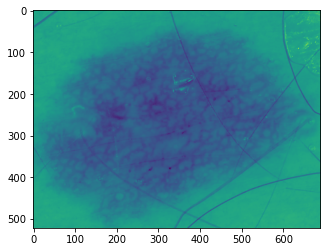

In [21]:
im = plt.imread('data/example_image/ISIC_0001769.jpg')
seg=plt.imread('data/example_segmentation/ISIC_0001769_segmentation.png')
les1 = Lesion("0001769", im, seg)
les1.edgeFlatCornerTexture(True)

(0.468319763138416, 0.22737786824574388, 0.24593819393042193)

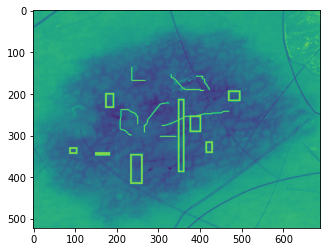

In [20]:
im1 = plt.imread('data/example_image/1test.jpg')
les2 = Lesion("1test", im1, seg)
les2.edgeFlatCornerTexture(True)